In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Helper Functions

The following cells contain functions used throughout the course of the question, they include model class creation, Glorot Initialization, Standardization of inputs and a function for creating data loaders for use during Pytorch training

In [2]:
#Initializes using Glorot Initialization
def GlorotInitialize(model):
    #Initialize parameters
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

class MLP_20(nn.Module):
    
    def __init__(self,insize,outsize):
        super(MLP_20,self).__init__()
        self.fc1 = nn.Linear(insize,100)
        self.fc2 = nn.Linear(100,outsize)
        self.insize = insize
        
    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        logits = self.fc2(h1)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices

In [3]:
def restructure_data(data):
    samples, vocab_size, max_word_count = np.max(data,axis=0)
    restructured_data = np.zeros((int(samples),int(vocab_size)))
    for i in range(len(data)):
        if (data[i,1]-1)<=vocab_size:
            restructured_data[int(data[i,0]-1),int(data[i,1]-1)]=data[i,2]
    return restructured_data

def tfidf(data):
    idf =  np.log(np.divide((data.shape[0]*np.ones_like(data)),1+np.sum(np.equal(data>0,1),axis=0)[None,:].astype(np.float)))
    return np.multiply(data,idf)

def make_loaders(data,labels,val_split,test_data=None,test_labels=None,batch_size=128):
    val_loader = 0
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    split = int(val_split*indices.shape[0])
    train_data, val_data = data[indices[:split],:], data[indices[split:],:]
    train_labels, val_labels = labels[indices[:split]], labels[indices[split:]]
    del indices
    print train_data.shape, train_labels.shape
    print val_data.shape, val_labels.shape
    
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data),torch.IntTensor(train_labels))
    del train_data
    del train_labels
    train_loader = torch.utils.data.DataLoader(train_tensor,batch_size=batch_size, shuffle = True)
    del train_tensor
    if val_split<1:
        val_tensor = torch.utils.data.TensorDataset(torch.Tensor(val_data), torch.IntTensor(val_labels))
        del val_data
        del val_labels
        val_loader = torch.utils.data.DataLoader(val_tensor,batch_size=batch_size, shuffle = True)
        del val_tensor
        
    if (type(test_data) != type(None)):
        test_tensor = torch.utils.data.TensorDataset(torch.Tensor(test_data),torch.IntTensor(test_labels))
        test_loader = torch.utils.data.DataLoader(test_tensor,batch_size=batch_size, shuffle = True)
        return train_loader, val_loader, test_loader

    return train_loader, val_loader


def standardize_data(data):
    s = StandardScaler()
    s.fit(data)
    s.var_ += 1e-5
    standardized_data = s.transform(data)
    return standardized_data

In [4]:
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None, verbose=True):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    loss_crit = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (test_correct/float(test_total))
            test_accuracy.append(test_acc)
            
        if (valLoader != None and testLoader != None and verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None and verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
        elif (verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)

In [5]:
def train_5000(model,train_loader,optimizer,loss_func, verbose= True):
    losses = [0]*5000
    batch_number = 0
    model = GlorotInitialize(model)
    for i in range(1000):
        for batch_index, (inputs, targets) in enumerate(train_loader):
            
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            loss = loss_func(logits,targets)
            
            loss.backward()
            optimizer.step()
            losses[batch_number] = (loss.data[0])
            if (verbose and batch_number%100==0):
                print "Iteration: " + repr(batch_number + 1) + " Loss: " + repr(loss.data[0])
            batch_number += 1
            if batch_number == 5000:
                plt.plot(losses, label='Train losses')
                plt.legend()
                plt.show()
                return model,losses

In [6]:
VocabSize = 47000
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

### 2.A Preprocessing

Here we will test different preprocessing methods on the data set. First we'll explore basic word counts, then tf-idf preprocessing and finally standardization of inputs

#### 2.A No preprocessing

In [7]:
countVect = CountVectorizer(max_features=VocabSize, stop_words='english')
countVect.fit(newsgroups_train.data)

count_train = countVect.transform(newsgroups_train.data)
count_test = countVect.transform(newsgroups_test.data)

count_train = count_train.todense()
count_test = count_test.todense()

train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [8]:
train_loader_ng_count,val_loader_ng_count, test_loader_ng_count = make_loaders(count_train,train_labels,
                                                                         0.2,count_test,test_labels)

(2262, 47000) (2262,)
(9052, 47000) (9052,)


##### Hyperparameter search for no preprocessing

Learning rate: 0.001
Epoch : 1 Loss : 2.998  Train Accuracy: 0.112 Validation Accuracy: 0.231 Test Accuracy: 0.208
Epoch : 2 Loss : 2.526  Train Accuracy: 0.405 Validation Accuracy: 0.434 Test Accuracy: 0.363
Epoch : 3 Loss : 1.737  Train Accuracy: 0.605 Validation Accuracy: 0.600 Test Accuracy: 0.520
Epoch : 4 Loss : 1.224  Train Accuracy: 0.722 Validation Accuracy: 0.507 Test Accuracy: 0.424
Epoch : 5 Loss : 1.583  Train Accuracy: 0.635 Validation Accuracy: 0.458 Test Accuracy: 0.395
Epoch : 6 Loss : 5.401  Train Accuracy: 0.559 Validation Accuracy: 0.460 Test Accuracy: 0.402
Epoch : 7 Loss : 59.874  Train Accuracy: 0.393 Validation Accuracy: 0.296 Test Accuracy: 0.250
Epoch : 8 Loss : 30.691  Train Accuracy: 0.381 Validation Accuracy: 0.283 Test Accuracy: 0.249
Epoch : 9 Loss : 22.383  Train Accuracy: 0.310 Validation Accuracy: 0.224 Test Accuracy: 0.185
Epoch : 10 Loss : 5.241  Train Accuracy: 0.371 Validation Accuracy: 0.226 Test Accuracy: 0.192
Epoch : 11 Loss : 4.978  Train Accu

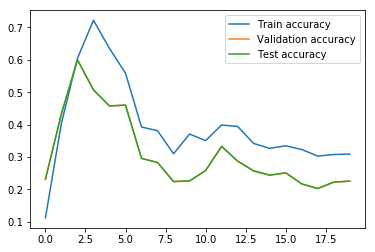

Learning rate: 0.0001
Epoch : 1 Loss : 3.031  Train Accuracy: 0.052 Validation Accuracy: 0.064 Test Accuracy: 0.060
Epoch : 2 Loss : 2.928  Train Accuracy: 0.162 Validation Accuracy: 0.190 Test Accuracy: 0.168
Epoch : 3 Loss : 2.800  Train Accuracy: 0.393 Validation Accuracy: 0.352 Test Accuracy: 0.303
Epoch : 4 Loss : 2.599  Train Accuracy: 0.540 Validation Accuracy: 0.445 Test Accuracy: 0.385
Epoch : 5 Loss : 2.313  Train Accuracy: 0.602 Validation Accuracy: 0.496 Test Accuracy: 0.428
Epoch : 6 Loss : 1.989  Train Accuracy: 0.655 Validation Accuracy: 0.532 Test Accuracy: 0.461
Epoch : 7 Loss : 1.675  Train Accuracy: 0.703 Validation Accuracy: 0.589 Test Accuracy: 0.515
Epoch : 8 Loss : 1.371  Train Accuracy: 0.775 Validation Accuracy: 0.654 Test Accuracy: 0.579
Epoch : 9 Loss : 1.100  Train Accuracy: 0.817 Validation Accuracy: 0.672 Test Accuracy: 0.587
Epoch : 10 Loss : 0.915  Train Accuracy: 0.818 Validation Accuracy: 0.622 Test Accuracy: 0.527
Epoch : 11 Loss : 0.824  Train Accura

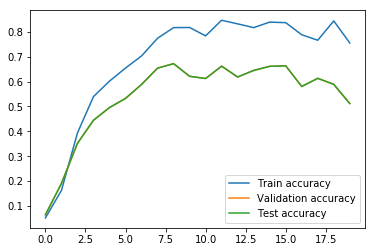

Learning rate: 1e-05
Epoch : 1 Loss : 3.018  Train Accuracy: 0.059 Validation Accuracy: 0.056 Test Accuracy: 0.055
Epoch : 2 Loss : 2.989  Train Accuracy: 0.069 Validation Accuracy: 0.067 Test Accuracy: 0.064
Epoch : 3 Loss : 2.966  Train Accuracy: 0.088 Validation Accuracy: 0.092 Test Accuracy: 0.079
Epoch : 4 Loss : 2.935  Train Accuracy: 0.125 Validation Accuracy: 0.127 Test Accuracy: 0.108
Epoch : 5 Loss : 2.897  Train Accuracy: 0.189 Validation Accuracy: 0.180 Test Accuracy: 0.154
Epoch : 6 Loss : 2.857  Train Accuracy: 0.269 Validation Accuracy: 0.235 Test Accuracy: 0.195
Epoch : 7 Loss : 2.804  Train Accuracy: 0.345 Validation Accuracy: 0.282 Test Accuracy: 0.238
Epoch : 8 Loss : 2.747  Train Accuracy: 0.410 Validation Accuracy: 0.327 Test Accuracy: 0.276
Epoch : 9 Loss : 2.681  Train Accuracy: 0.458 Validation Accuracy: 0.364 Test Accuracy: 0.306
Epoch : 10 Loss : 2.607  Train Accuracy: 0.504 Validation Accuracy: 0.393 Test Accuracy: 0.333
Epoch : 11 Loss : 2.522  Train Accurac

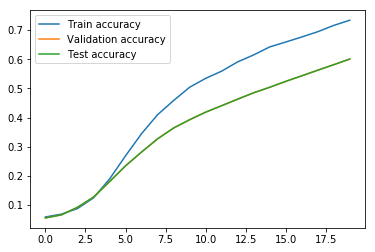

Learning rate: 1e-06
Epoch : 1 Loss : 3.055  Train Accuracy: 0.049 Validation Accuracy: 0.043 Test Accuracy: 0.048
Epoch : 2 Loss : 3.051  Train Accuracy: 0.050 Validation Accuracy: 0.045 Test Accuracy: 0.048
Epoch : 3 Loss : 3.006  Train Accuracy: 0.052 Validation Accuracy: 0.046 Test Accuracy: 0.049
Epoch : 4 Loss : 3.001  Train Accuracy: 0.053 Validation Accuracy: 0.047 Test Accuracy: 0.050
Epoch : 5 Loss : 2.994  Train Accuracy: 0.054 Validation Accuracy: 0.050 Test Accuracy: 0.051
Epoch : 6 Loss : 2.986  Train Accuracy: 0.061 Validation Accuracy: 0.053 Test Accuracy: 0.053
Epoch : 7 Loss : 2.977  Train Accuracy: 0.066 Validation Accuracy: 0.060 Test Accuracy: 0.057
Epoch : 8 Loss : 2.968  Train Accuracy: 0.078 Validation Accuracy: 0.066 Test Accuracy: 0.061
Epoch : 9 Loss : 2.958  Train Accuracy: 0.092 Validation Accuracy: 0.076 Test Accuracy: 0.069
Epoch : 10 Loss : 2.948  Train Accuracy: 0.111 Validation Accuracy: 0.086 Test Accuracy: 0.078
Epoch : 11 Loss : 2.938  Train Accurac

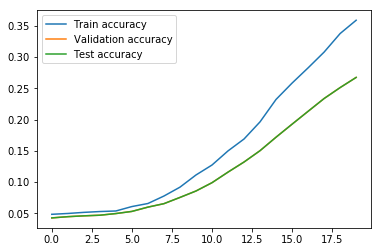

In [9]:
lrs = [1e-3,1e-4,1e-5,1e-6]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_count,optimizer,val_loader_ng_count,
                             test_loader_ng_count)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(val_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

Optimal learning rate was found to be 1e-05

#### 2.A TF-IDF Preprocessing

In [7]:
tfidfVect = TfidfVectorizer(max_features=VocabSize,stop_words='english')
tfidfVect.fit(newsgroups_train.data)

tfidf_train = tfidfVect.transform(newsgroups_train.data)
tfidf_test = tfidfVect.transform(newsgroups_test.data)


tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()
train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [9]:
train_loader_ng_tfidf,val_loader_ng_tfidf, test_loader_ng_tfidf = make_loaders(tfidf_train,train_labels,
                                                                         0.2,tfidf_test,test_labels)

(2262, 45000) (2262,)
(9052, 45000) (9052,)


##### Hyperparameter search for TFIDF preprocessing

Learning rate: 0.01
Epoch : 1 Loss : 2.994  Train Accuracy: 0.057 Validation Accuracy: 0.062 Test Accuracy: 0.065
Epoch : 2 Loss : 2.982  Train Accuracy: 0.071 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 3 Loss : 2.947  Train Accuracy: 0.100 Validation Accuracy: 0.134 Test Accuracy: 0.123
Epoch : 4 Loss : 2.883  Train Accuracy: 0.257 Validation Accuracy: 0.145 Test Accuracy: 0.131
Epoch : 5 Loss : 2.811  Train Accuracy: 0.163 Validation Accuracy: 0.170 Test Accuracy: 0.162
Epoch : 6 Loss : 3.003  Train Accuracy: 0.268 Validation Accuracy: 0.161 Test Accuracy: 0.133
Epoch : 7 Loss : 5.735  Train Accuracy: 0.154 Validation Accuracy: 0.161 Test Accuracy: 0.159
Epoch : 8 Loss : 12.518  Train Accuracy: 0.098 Validation Accuracy: 0.076 Test Accuracy: 0.074
Epoch : 9 Loss : 4.711  Train Accuracy: 0.056 Validation Accuracy: 0.054 Test Accuracy: 0.052
Epoch : 10 Loss : 4.105  Train Accuracy: 0.053 Validation Accuracy: 0.058 Test Accuracy: 0.058
Epoch : 11 Loss : 4.707  Train Accurac

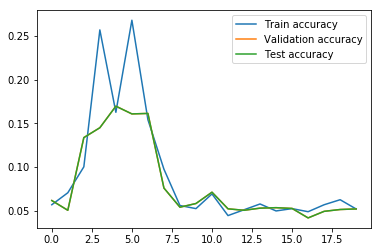

Learning rate: 0.001
Epoch : 1 Loss : 2.996  Train Accuracy: 0.050 Validation Accuracy: 0.055 Test Accuracy: 0.055
Epoch : 2 Loss : 2.993  Train Accuracy: 0.068 Validation Accuracy: 0.057 Test Accuracy: 0.058
Epoch : 3 Loss : 2.986  Train Accuracy: 0.090 Validation Accuracy: 0.078 Test Accuracy: 0.079
Epoch : 4 Loss : 2.977  Train Accuracy: 0.080 Validation Accuracy: 0.052 Test Accuracy: 0.053
Epoch : 5 Loss : 2.964  Train Accuracy: 0.062 Validation Accuracy: 0.055 Test Accuracy: 0.054
Epoch : 6 Loss : 2.950  Train Accuracy: 0.099 Validation Accuracy: 0.098 Test Accuracy: 0.094
Epoch : 7 Loss : 2.927  Train Accuracy: 0.187 Validation Accuracy: 0.195 Test Accuracy: 0.181
Epoch : 8 Loss : 2.893  Train Accuracy: 0.333 Validation Accuracy: 0.328 Test Accuracy: 0.298
Epoch : 9 Loss : 2.853  Train Accuracy: 0.511 Validation Accuracy: 0.490 Test Accuracy: 0.462
Epoch : 10 Loss : 2.802  Train Accuracy: 0.759 Validation Accuracy: 0.607 Test Accuracy: 0.543
Epoch : 11 Loss : 2.741  Train Accurac

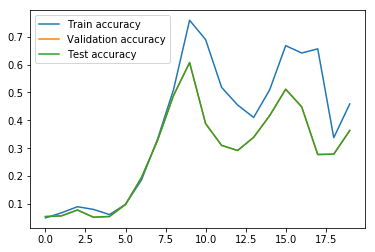

Learning rate: 0.0001
Epoch : 1 Loss : 2.996  Train Accuracy: 0.050 Validation Accuracy: 0.055 Test Accuracy: 0.051
Epoch : 2 Loss : 2.995  Train Accuracy: 0.064 Validation Accuracy: 0.058 Test Accuracy: 0.055
Epoch : 3 Loss : 2.994  Train Accuracy: 0.071 Validation Accuracy: 0.057 Test Accuracy: 0.061
Epoch : 4 Loss : 2.993  Train Accuracy: 0.077 Validation Accuracy: 0.056 Test Accuracy: 0.057
Epoch : 5 Loss : 2.991  Train Accuracy: 0.067 Validation Accuracy: 0.052 Test Accuracy: 0.054
Epoch : 6 Loss : 2.989  Train Accuracy: 0.060 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 7 Loss : 2.986  Train Accuracy: 0.060 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 8 Loss : 2.983  Train Accuracy: 0.060 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 9 Loss : 2.980  Train Accuracy: 0.060 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 10 Loss : 2.977  Train Accuracy: 0.060 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 11 Loss : 2.973  Train Accura

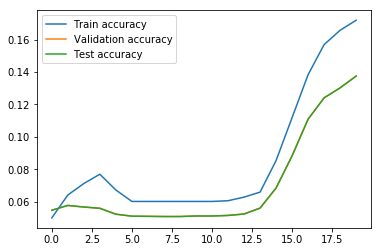

Learning rate: 1e-05
Epoch : 1 Loss : 2.995  Train Accuracy: 0.052 Validation Accuracy: 0.053 Test Accuracy: 0.049
Epoch : 2 Loss : 2.995  Train Accuracy: 0.052 Validation Accuracy: 0.053 Test Accuracy: 0.049
Epoch : 3 Loss : 2.995  Train Accuracy: 0.054 Validation Accuracy: 0.057 Test Accuracy: 0.050
Epoch : 4 Loss : 2.995  Train Accuracy: 0.057 Validation Accuracy: 0.058 Test Accuracy: 0.053
Epoch : 5 Loss : 2.995  Train Accuracy: 0.065 Validation Accuracy: 0.060 Test Accuracy: 0.054
Epoch : 6 Loss : 2.995  Train Accuracy: 0.070 Validation Accuracy: 0.064 Test Accuracy: 0.057
Epoch : 7 Loss : 2.994  Train Accuracy: 0.078 Validation Accuracy: 0.065 Test Accuracy: 0.058
Epoch : 8 Loss : 2.994  Train Accuracy: 0.084 Validation Accuracy: 0.067 Test Accuracy: 0.060
Epoch : 9 Loss : 2.994  Train Accuracy: 0.088 Validation Accuracy: 0.066 Test Accuracy: 0.061
Epoch : 10 Loss : 2.993  Train Accuracy: 0.086 Validation Accuracy: 0.067 Test Accuracy: 0.060
Epoch : 11 Loss : 2.993  Train Accurac

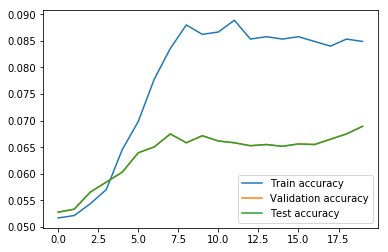

In [12]:
lrs = [1e-2,1e-3,1e-4,1e-5]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_tfidf,optimizer,val_loader_ng_tfidf, test_loader_ng_tfidf)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(val_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

Optimal learning rate was found to be ####

#### 2.A Standardization of input features

In [ ]:
countVect = CountVectorizer(max_features=VocabSize, stop_words='english')
countVect.fit(newsgroups_train.data)

stand_train = countVect.transform(newsgroups_train.data)
stand_test = countVect.transform(newsgroups_test.data)

stand_train = count_train.todense()
stand_test = count_test.todense()

stand_train = standardize(stand_train)
stand_test = standardize(stand_test)

train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [ ]:
train_loader_ng_stand, val_loader_ng_stand, test_loader_ng_stand = (stand_train,train_labels,
                                                                         0.2,stand_test,test_labels)

##### Hyperparameter search for Standardized features preprocessing

In [ ]:
lrs = [1e-2,1e-3,1e-4,1e-5]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_stand,optimizer,val_loader_ng_stand, test_loader_ng_stand)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(val_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

Optimal learning rate was found to be 

##### 2.A.1
Blah blah blah


##### 2.A.2.a

##### 2.A.2.b

##### 2.A.2.c


### 2.B Variance in Training

In [71]:
#Variance
train_loader_newsgroups_tfidf,val_loader_newsgroups_tfidf = make_loaders(tfidf_train,labels,0.2,batch_size=1)

(2262, 51000) (2262,)
(9052, 51000) (9052,)


Iteration: 1 Loss: 2.9911415576934814
Iteration: 101 Loss: 8.209311485290527
Iteration: 201 Loss: 3.947127103805542
Iteration: 301 Loss: 13.644200325012207
Iteration: 401 Loss: 29.123924255371094
Iteration: 501 Loss: 15.53041934967041
Iteration: 601 Loss: 60.98590087890625
Iteration: 701 Loss: 36.75482940673828
Iteration: 801 Loss: 70.56136322021484
Iteration: 901 Loss: 0.6593083739280701
Iteration: 1001 Loss: 15.070040702819824
Iteration: 1101 Loss: 26.461891174316406
Iteration: 1201 Loss: 85.29875946044922
Iteration: 1301 Loss: 11.012137413024902
Iteration: 1401 Loss: 16.104990005493164
Iteration: 1501 Loss: 19.191856384277344
Iteration: 1601 Loss: 27.384374618530273
Iteration: 1701 Loss: 86.47927856445312
Iteration: 1801 Loss: 33.72285461425781
Iteration: 1901 Loss: 136.58799743652344
Iteration: 2001 Loss: 110.37047576904297
Iteration: 2101 Loss: 19.44373321533203
Iteration: 2201 Loss: 39.25526428222656
Iteration: 2301 Loss: 78.48477935791016
Iteration: 2401 Loss: 268.96356201171875

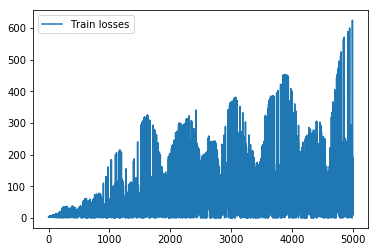

In [72]:
var_model = MLP_20(VocabSize,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader_newsgroups_tfidf,optimizer,loss_func)

In [73]:
#Variance
train_loader_newsgroups_tfidf,val_loader_newsgroups_tfidf = make_loaders(tfidf_train,labels,0.2,batch_size=100)

(2262, 51000) (2262,)
(9052, 51000) (9052,)


Iteration: 1 Loss: 2.995349168777466
Iteration: 101 Loss: 1.620274305343628
Iteration: 201 Loss: 0.07005771994590759
Iteration: 301 Loss: 1.1670720390100087e-08
Iteration: 401 Loss: 3.887366872845632e-09
Iteration: 501 Loss: 0.10409103333950043
Iteration: 601 Loss: 6.89327407599194e-06
Iteration: 701 Loss: 0.0
Iteration: 801 Loss: 0.2603533864021301
Iteration: 901 Loss: 0.45846861600875854
Iteration: 1001 Loss: 0.9959257245063782
Iteration: 1101 Loss: 5.619957447052002
Iteration: 1201 Loss: 9.308954238891602
Iteration: 1301 Loss: 10.3549165725708
Iteration: 1401 Loss: 5.453075408935547
Iteration: 1501 Loss: 7.036613941192627
Iteration: 1601 Loss: 72.3508071899414
Iteration: 1701 Loss: 3.0873632431030273
Iteration: 1801 Loss: 12.068994522094727
Iteration: 1901 Loss: 1.5484179258346558
Iteration: 2001 Loss: 329.15313720703125
Iteration: 2101 Loss: 218.23902893066406
Iteration: 2201 Loss: 500.34100341796875
Iteration: 2301 Loss: 0.0
Iteration: 2401 Loss: 0.0
Iteration: 2501 Loss: 688.2237

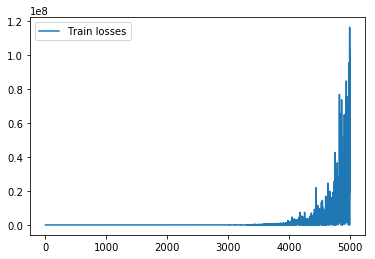

In [74]:
var_model = MLP_20(VocabSize,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader_newsgroups_tfidf,optimizer,loss_func)